In [21]:
import torch
import os
import tiktoken
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

device = 'mps'

In [22]:
torch.__version__

'2.2.0.dev20231129'

In [11]:
import json
import os
from tqdm import tqdm

in_file = "/Volumes/External/EleutherAI_ThePile_v1/pile/test.jsonl"
out_file = "data/pile_test.txt"
os.makedirs('data', exist_ok=True)

with open(out_file, 'w+') as out_f:
    with open(in_file, 'r') as in_f:
        for line in tqdm(in_f):
            json_data = json.loads(line)
            out_f.write(json_data['text'])

214584it [00:36, 5958.34it/s]


In [12]:
out_file = "data/pile.txt"

with open(out_file, 'r') as data_f:
    text = data_f.read()

print(text[:600])
print(len(text))

Catalonia election: Puigdemont calls for talks with Spain Published duration 22 December 2017 Related Topics Catalonia independence protests

image copyright Reuters image caption "Now is the time for dialogue," said Carles Puigdemont

Catalonia's ousted leader, Carles Puigdemont, has called for new talks with Spain after separatist parties won a slim majority in a regional election.

He said he wanted the negotiations in Brussels, where he is living in self-imposed exile, or another EU country.

Spain's Prime Minister Mariano Rajoy later appeared to reject the idea.

He said he would hold tal
2636198233


In [17]:
import tiktoken
import h5py

n = int(0.9 * len(text))
train_text = text[:n]
dev_text = text[n:]


enc = tiktoken.get_encoding('r50k_base')

chunk_size = 10000

for fname, text_split in zip(['data/pile_train.h5', 'data/pile_dev.h5'], [train_text, dev_text]):
    with h5py.File(fname, 'w') as f:
        dataset = f.create_dataset('indices', (0,), maxshape=(None,), dtype='i')
        # Fill the dataset in chunks
        start_index = 0
        for i in tqdm(range((len(text_split) // chunk_size) + 1)):
            encoded_chunk = enc.encode(text[i*chunk_size:(i+1)*chunk_size])
            chunk_len = len(encoded_chunk)
            end_index = start_index + chunk_len
            dataset.resize(dataset.shape[0] + chunk_len, axis=0)
            dataset[start_index:end_index] = encoded_chunk
            start_index = end_index

100%|███████████████████████████████████| 26362/26362 [00:22<00:00, 1146.90it/s]


In [84]:
import numpy as np

train_path = "data/pile_train.h5"
dev_path = "data/pile_dev.h5"
batch_size = 16
context_length = 128

def get_batch_iterator(split, batch_size=batch_size, context_length=context_length):
    hdf5_path = train_path if split=='train' else dev_path
    with h5py.File(hdf5_path, 'r') as hdf5_file:
        while True:
            dataset = hdf5_file['indices']
            dataset_size = dataset.shape[0]
            random_indices = torch.randint(dataset_size-context_length, size=(batch_size,))
            random_samples = torch.tensor(np.array([dataset[idx:idx+context_length+1] for idx in random_indices]))
            xb = random_samples[:, :context_length].to(device)
            yb = random_samples[:, 1:context_length+1].to(device)
            yield xb, yb

batch_iterator = get_batch_iterator('train')

In [96]:
xb, yb = next(batch_iterator)

for row in xb:
    print(enc.decode(row.tolist()))
    print('\n\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n\n')

 past the officer who had just finished his inspection of the back door. AJ and me followed him. We all dropped our backpacks in the lawn chairs on the back porch and started across the lawn. In silence, Scooter walked over to the tree and got the key. (That reminds me: we really need to make a few copies of that thing.) After making sure no one was watching, he entered what was now our secret entrance. He made his way to the manhole cover, opened it, and descended the ladder.

Not really sure what he was up to, AJ and me just followed him without saying a word


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


 tried solving my equation over and over again but I can't seem to understand why my solution is different from mathematica's. The only I thought about was possibly in the substitution of arbitrary constant. Am I missing something obvious here?

A:

You forgot the integration constant. Following on from your integral for $T(t)$, we find
\begin{align}
T(t)e^{\alpha t} &= \int 2 \m

In [86]:
import math

torch.manual_seed(1)
n_head = 4

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(n_embed, 4*n_embed)
        self.relu = nn.ReLU()
        self.proj = nn.Linear(4*n_embed, n_embed)

    def forward(self, x):
        x = self.forward_embedding(x)
        x = self.project_embedding(x)
        return x

    def forward_embedding(self, x):
        x = self.relu(self.hidden(x))
        return x

    def project_embedding(self, x):
        x = self.proj(x)
        return x
        

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length)))

    def forward(self, x):
        # out = nn.scaled_dot_product_attention(self.key, self.query, self.value, causal=True)
        # return out

        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        scale_factor = 1 / math.sqrt(C)
        attn_weights = q @ k.transpose(-2, -1) * scale_factor
        attn_weights = attn_weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        attn_weights = F.softmax(attn_weights, dim=-1)
        v = self.value(x)
        out = attn_weights @ v
        return out
        
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.heads = nn.ModuleList([Head(n_embed//n_head) for _ in range(n_head)])

    def forward(self, x):
        x = torch.cat([h(x) for h in self.heads], dim=-1)
        return x

class Block(nn.Module):
    def __init__(self):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embed)
        self.attn = MultiHeadAttention()
        self.ln2 = nn.LayerNorm(n_embed)
        self.mlp = MLP()

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        # x = x + self.attn(x)
        # x = x + self.mlp(x)
        return x

    def forward_ablation(self, x, autoencoder):
        x, res = self.forward_embedding(x)
        x, _, _ = autoencoder(x)
        x = res + self.mlp.project_embedding(x)
        return x

    def forward_embedding(self, x):
        res = x + self.attn(self.ln1(x))
        x = self.mlp.forward_embedding(self.ln2(res))
        return x, res

In [87]:
import torch.nn as nn
import torch.nn.functional as F

vocab_size = 50304
n_embed = 128

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, n_embed)
        self.position_embed = nn.Embedding(context_length, n_embed)
        self.attn_block = Block()
        self.layer_norm = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def _pre_attn_pass(self, idx):
        B, T = idx.shape
        tok_embedding = self.token_embed(idx)
        pos_embedding = self.position_embed(torch.arange(T, device=device))
        return tok_embedding + pos_embedding

    def forward(self, idx, targets=None):
        x = self._pre_attn_pass(idx)
        x = self.attn_block(x)
        x = self.layer_norm(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            flat_logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(flat_logits, targets)
        return logits, loss

    def forward_embedding(self, idx):
        x = self._pre_attn_pass(idx)
        x, residual = self.attn_block.forward_embedding(x)
        return x, residual

    def forward_ablation(self, idx, autoencoder, targets=None):
        x = self._pre_attn_pass(idx)
        x = self.attn_block.forward_ablation(x, autoencoder)
        x = self.layer_norm(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            flat_logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(flat_logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -context_length:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

    def generate_ablation(self, idx, max_new_tokens, autoencoder):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -context_length:]
            logits, _ = self.forward_ablation(idx_cond, autoencoder)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [88]:
def count_params(m):
    print(sum(p.numel() for p in m.parameters()))

In [89]:
model = Transformer()
model = model.to(device)
print(model)
count_params(model)

Transformer(
  (token_embed): Embedding(50304, 128)
  (position_embed): Embedding(128, 128)
  (attn_block): Block(
    (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (attn): MultiHeadAttention(
      (heads): ModuleList(
        (0-3): 4 x Head(
          (key): Linear(in_features=128, out_features=32, bias=False)
          (query): Linear(in_features=128, out_features=32, bias=False)
          (value): Linear(in_features=128, out_features=32, bias=False)
        )
      )
    )
    (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (mlp): MLP(
      (hidden): Linear(in_features=128, out_features=512, bias=True)
      (relu): ReLU()
      (proj): Linear(in_features=512, out_features=128, bias=True)
    )
  )
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=128, out_features=50304, bias=True)
)
13126144


In [97]:
eval_iters = 20

@torch.no_grad()
def estimate_loss(steps=eval_iters):
    out = {}
    model.eval()
    for split in ['train', 'dev']:
        batch_iterator = get_batch_iterator(split)
        losses = torch.zeros(steps)
        for k in tqdm(range(steps)):
            xb, yb = next(batch_iterator)
            logist, loss = model(xb, yb)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [91]:
estimate_loss()

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 43.28it/s]


{'train': tensor(11.0020), 'dev': tensor(11.0020)}

In [92]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
losses = []

Train loss: 4.3383: 100%|█████████████| 140000/140000 [6:10:08<00:00,  6.30it/s]


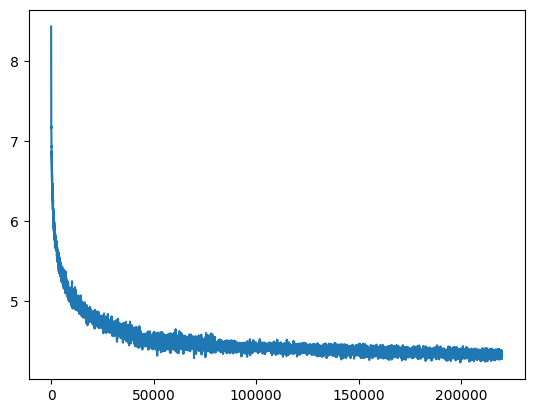

100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 37.35it/s]


{'train': tensor(4.3571), 'dev': tensor(4.3358)}

In [169]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

batch_size = 32
n_steps = 140000
avg_window = 64

batch_iterator = get_batch_iterator('train', batch_size, context_length)

pbar = tqdm(range(n_steps))
for steps in pbar:
    xb, yb = next(batch_iterator)
    logits, loss = model(xb, yb)
    losses.append(loss.item())
    pbar.set_description(f"Train loss: {np.mean(losses[-avg_window:]):.4f}")
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot(moving_average(losses, avg_window))
plt.show()
estimate_loss(200)

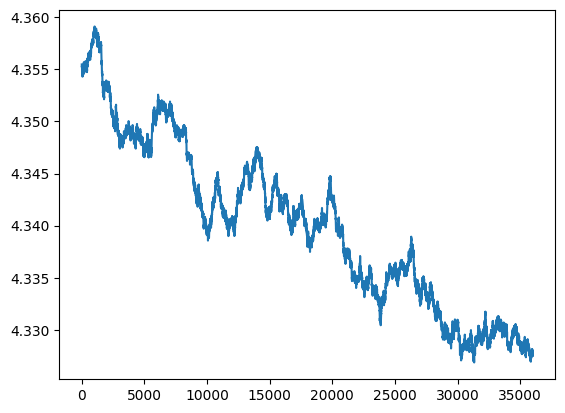

In [172]:
plt.plot(moving_average(losses[-40000:], 4000))
plt.show()

In [127]:
for g in optimizer.param_groups:
    g['lr'] = 1e-4

In [178]:
train_loss, dev_loss = estimate_loss(1000).values()
train_loss, dev_loss

100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 39.07it/s]


(tensor(4.3340), tensor(4.3372))

In [179]:
model_path = f"models/transformer_pile_128_0_4.3340.pt"

In [180]:
os.makedirs('models', exist_ok=True)

if not os.path.exists(model_path):
    torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'losses': losses,
                'train_loss': train_loss,
                'dev_loss': dev_loss,
                'steps': len(losses),
                }, model_path)

In [13]:
checkpoint = torch.load(path)
model = Transformer().to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [177]:
idx = torch.tensor(enc.encode('\n'), dtype=torch.long)[None, :].to(device)
# torch.manual_seed(1)
with torch.no_grad():
    print(enc.decode(model.generate(idx, 128)[0].tolist()))



Player.done about 'share',

record-js', 'conffunc) {

    bind.smognate(builder string_c<Path, <versionpathname>button
       // select string
if
       # initialized by patch number should function cOPHeaderOfNull(negresa)
   
 	if optionally plugin:
	.textfile.socket("errorb_started")
	let is used as used to create tons with google
	 <vfx embeds()
	}

#


In [15]:
class SparseAutoencoder(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.encoder = nn.Linear(n_embed * 4, n_features)
        self.decoder = nn.Linear(n_features, n_embed * 4)
        # self.decoder_bias = nn.Parameter(torch.zeros(n_embed * 4))  # explicitly define decoder bias so we can subtract it from the input
        self.relu = nn.ReLU()

    def forward(self, x_in, compute_loss=False):
        f = self.encode(x_in)
        x = self.decoder(f)
        if compute_loss:
            recon_loss = F.mse_loss(x, x_in)
            reg_loss = f.abs().sum(dim=-1).mean()
            loss = recon_loss + reg_loss
        else:
            recon_loss = None
            reg_loss = None
        return x, recon_loss, reg_loss

    def encode(self, x_in):
        x = x_in - self.decoder.bias
        f = self.relu(self.encoder(x))
        return f

    def normalize_decoder_weights(self):
        with torch.no_grad():
            self.decoder.weight.data = nn.functional.normalize(self.decoder.weight.data, p=2, dim=1)

In [274]:
batch_size = 256

num_batches = len(train_data)

def iterate_data(split, batch_size=batch_size):
    data = train_data if split == 'train' else dev_data
    rows = data[:len(data) - len(data) % (context_length*batch_size)].view(-1, batch_size, context_length)
    print(f"batches: {rows.shape[0]}")
    for batch in rows:
        yield batch

batch_iterator = iterate_data('train')

In [265]:
import h5py

hdf5_path = 'data/embeddings_0.hdf5'

with h5py.File(hdf5_path, 'w') as hdf5_file:
    with torch.no_grad():
        maxshape = (None, n_embed*4)
        dataset = hdf5_file.create_dataset('tensors', (0, n_embed*4), maxshape=maxshape, dtype='float32')
        
        for batch in tqdm(batch_iterator):
            embedding = model.forward_embedding(batch.to(device))
            flattened_embedding = embedding.view(-1, n_embed*4)
    
            # Append the flattened tensor to the HDF5 dataset
            dataset.resize((dataset.shape[0] + flattened_embedding.shape[0]), axis=0)
            dataset[-flattened_embedding.shape[0]:] = flattened_embedding.cpu().numpy()


OSError: Unable to create file (unable to truncate a file which is already open)

In [20]:
import numpy as np

batch_size = 128

def iterate_embeddings(batch_size):
    with h5py.File(hdf5_path, 'r') as hdf5_file:
        while True:
            dataset = hdf5_file['tensors']
            dataset_size = dataset.shape[0]
            random_indices = torch.randint(dataset_size, size=(batch_size,))
            random_samples = torch.tensor(np.array([dataset[idx] for idx in random_indices]))
            yield random_samples

embedding_iterator = iterate_embeddings(batch_size)

In [86]:
next(embedding_iterator).shape

torch.Size([128, 512])

In [16]:
autoencoder = SparseAutoencoder(4096).to(device)
count_params(autoencoder)
autoencoder

4198912


SparseAutoencoder(
  (encoder): Linear(in_features=512, out_features=4096, bias=True)
  (decoder): Linear(in_features=4096, out_features=512, bias=True)
  (relu): ReLU()
)

In [18]:
train_steps = 20000
lambda_reg = 0.002
batch_size = 128
lr = 1e-5

autoencoder = SparseAutoencoder(4096).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
losses = []
recon_losses = []
reg_losses = []

0.053: 100%|██████████████████████████████| 20000/20000 [34:12<00:00,  9.74it/s]


Loss:	0.071
Recon:	0.051
Reg:	0.020


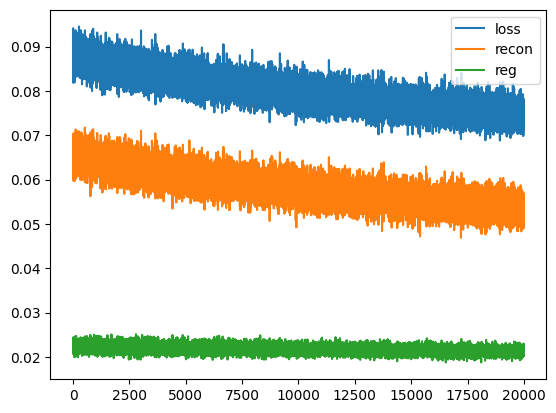

In [40]:
import matplotlib.pyplot as plt
import h5py
hdf5_path = 'data/embeddings_0.hdf5'

batch_size = 128
losses = []
recon_losses = []
reg_losses = []
embedding_iterator = iterate_embeddings(batch_size)

pbar = tqdm(range(train_steps))

for _ in pbar:
    xb, _ = get_batch('train', batch_size)
    # with torch.no_grad():
    #     x_embedding = model.forward_embedding(xb)
    #     print(x_embedding.shape)
    # break
    x_embedding = next(embedding_iterator).to(device)
    optimizer.zero_grad()
    outputs, recon_loss, reg_loss = autoencoder(x_embedding, compute_loss=True)
    reg_loss = lambda_reg * reg_loss
    loss = recon_loss + reg_loss
    loss.backward()
    optimizer.step()
    autoencoder.normalize_decoder_weights()
    
    losses.append(loss.item())
    recon_losses.append(recon_loss.item())
    reg_losses.append(reg_loss.item())

    pbar.set_description(f"{np.mean(recon_losses[-100:]):.3f}")

print(f"Loss:\t{loss:.3f}\nRecon:\t{recon_loss:.3f}\nReg:\t{reg_loss:.3f}")
plt.plot(losses, label='loss')
plt.plot(recon_losses, label='recon')
plt.plot(reg_losses, label='reg')
plt.legend()
plt.show()

In [55]:
path = "models/autoencoder_1.pt"

os.makedirs('models', exist_ok=True)

if not os.path.exists(path):
    torch.save({
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'losses': losses,
                'steps': len(losses),
                }, path)

In [39]:
path = "models/autoencoder_1.pt"

checkpoint = torch.load(path)
autoencoder.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [43]:
identity = lambda x: (x, None, None)
idx = torch.tensor(enc.encode('\n'), dtype=torch.long)[None, :].to(device)
# torch.manual_seed(1)
with torch.no_grad():
    print(enc.decode(model.generate_ablation(idx, 128, autoencoder)[0].tolist()))


S Smith, Gary N NTT/HOU/ECT@ECT, Alan Aronowitz, Susan 
	 
	catalog/HOU/ECT@EES, gdan.har@enron.com, 
	marcelise.liss, Clayton.mull@enron.com, kourtney@enron.com, mark.malzman@enron.com, tom.del@enron.com, 
	john.mull@enron.com, james.lbas@enron.com, kevin.dro@enron.


100%|█████████████████████████████████████████| 160/160 [00:59<00:00,  2.68it/s]


0.9375


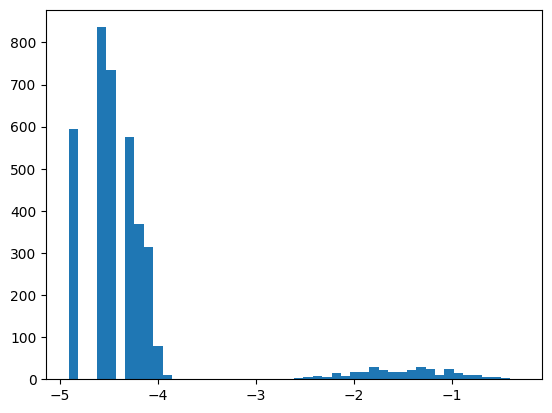

In [44]:
batch_size = 512
embedding_iterator = iterate_embeddings(batch_size)

def feature_density_histogram(num_samples=16384):
    all_outputs = []
    for i in tqdm(range(num_samples // batch_size)):
        batch = next(embedding_iterator).to(device)
        outputs = autoencoder.encode(batch)  # (128, 4096)
        all_outputs.append(outputs)
    output_stack = torch.concat(all_outputs)
    return output_stack

output_stack = feature_density_histogram(16384*5)

B, C = output_stack.shape
activation_densities = (output_stack > 1e-4).to(torch.float32).mean(dim=0)
activation_densities = activation_densities[activation_densities > 0]
activation_densities = activation_densities.log10()
print(activation_densities.shape[0]/4096)
plt.hist(activation_densities.cpu(), bins=48)
plt.show()

# We want nearly all features to be below 1% density: "The number of features with density above 1%. A significant number of features above this level seems to correspond to an L1 coefficient that is too low."

In [54]:
(activation_densities > -1).sum()

tensor(56, device='mps:0')

In [45]:
print(f"{(((output_stack > 1e-4).to(torch.float32).mean(dim=0) > 0).sum().item() / 4096 * 100):.2f}%")

93.75%


In [46]:
batch_size = 4096
embedding_iterator = iterate_embeddings(batch_size)
x_embedding = next(embedding_iterator).to(device)

activation_counts = (autoencoder.encode(x_embedding) > 1e-3 * 1.0).sum(dim=-1).to(torch.float32)
print(f"Median:\t{activation_counts.median().item()}\nMean:\t{activation_counts.mean().item():.2f}\nStd:\t{activation_counts.std().item():.2f}")
# median number of hot features per token for each element in the batch, want to be "less than 10 or 20" as per paper

# "we generally target a L^0 norm that is less than 10 or 20. We especially distrust solutions where the L^0 norm is a significant fraction of the transformer’s activation dimensionality.

Median:	18.0
Mean:	18.94
Std:	7.17


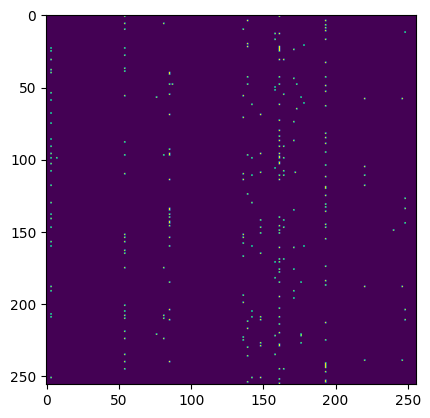

In [47]:
with torch.no_grad():
    out = autoencoder.encode(x_embedding) > 1e-3
B, C = out.shape
plt.imshow(out.cpu()[:256, :256])

In [1152]:
# print(autoencoder(x))
for vec in x_embedding:
    hot = ((autoencoder.encode(vec) > 1e-4) * 1).sum(dim=1)
    print(hot.sum())

tensor(679, device='mps:0')
tensor(685, device='mps:0')
tensor(619, device='mps:0')
tensor(551, device='mps:0')
tensor(606, device='mps:0')
tensor(631, device='mps:0')
tensor(496, device='mps:0')
tensor(634, device='mps:0')
tensor(540, device='mps:0')
tensor(517, device='mps:0')
tensor(495, device='mps:0')
tensor(579, device='mps:0')
tensor(587, device='mps:0')
tensor(579, device='mps:0')
tensor(580, device='mps:0')
tensor(730, device='mps:0')
tensor(677, device='mps:0')
tensor(537, device='mps:0')
tensor(599, device='mps:0')
tensor(476, device='mps:0')
tensor(774, device='mps:0')
tensor(541, device='mps:0')
tensor(527, device='mps:0')
tensor(482, device='mps:0')
tensor(531, device='mps:0')
tensor(457, device='mps:0')
tensor(566, device='mps:0')
tensor(508, device='mps:0')
tensor(500, device='mps:0')
tensor(483, device='mps:0')
tensor(519, device='mps:0')
tensor(537, device='mps:0')
tensor(531, device='mps:0')
tensor(545, device='mps:0')
tensor(446, device='mps:0')
tensor(548, device='

In [476]:
!git a && git c 'add function to forward pass transformer using autoencoder for MLP activations'

[main 81e9b8e] add function to forward pass transformer using autoencoder for MLP activations
 1 file changed, 240 insertions(+), 204 deletions(-)


In [35]:
xb, yb = get_batch('train', 64)
print(xb.shape)

with torch.no_grad():
    t_logits, t_loss = model(xb, yb)
    a_logits, a_loss = model.forward_ablation(xb, autoencoder, yb)

print(t_loss, a_loss)

torch.Size([64, 128])
tensor(2.5114, device='mps:0') tensor(3.3334, device='mps:0')


In [63]:
def get_features(x):
    embedding, _ = model.forward_embedding(x)
    features = autoencoder.encode(embedding)
    return features

features = get_features(xb)

print(features.shape, xb.shape)

torch.Size([128, 128, 4096]) torch.Size([128, 128])


In [230]:
feature_dict = {i: [0, []] for i in range(4096)}
context_list = []

threashold = 0.5

num_iters = 32000
batch_size = 16
samples_per_row = 4

for _ in tqdm(range(num_iters)):
    xb, _ = get_batch("train", batch_size)
    features = get_features(xb)
    features = features.cpu()
    for i, row in enumerate(xb):  # iterate thru rows in a batch
        # for j in range(row.shape[0]):  # iterate thru tokens in a row
        for j in np.random.choice(row.shape[0], samples_per_row, replace=False):  #torch.randint(row.shape[0], (samples_per_row,), replact=False):
            token = xb[i, j]
            context = xb[i, max(j-4, 0):j+5]
            context_list.append((token.item(), context.tolist()))
            context_idx = len(context_list) - 1
            
            feature_vec = features[i, j]
            activation_idxs = (feature_vec > threashold).nonzero()
            
            for a_idx in activation_idxs:
                a_idx = a_idx[0].item()
                feature_dict[a_idx][0] += 1
                if feature_dict[a_idx][0] < 512:
                    feature_dict[a_idx][1].append((context_idx, feature_vec[a_idx].item()))



100%|█████████████████████████████████████| 32000/32000 [11:45<00:00, 45.34it/s]


In [231]:
sum([len(l[1]) > 1 for l in feature_dict.values()])

330

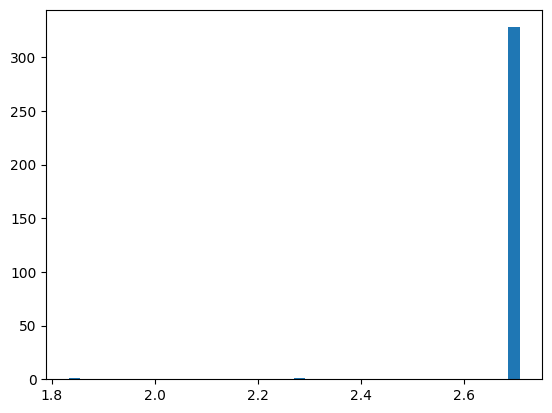

In [232]:
plt.hist([math.log10(len(ctx[1])) for ctx in feature_dict.values() if len(ctx[1]) > 0], bins=40)
plt.show()

In [233]:
sorted_dict = sorted(feature_dict.items(), key = lambda x: x[1][0] if x[1][0] else 999999)[:10]

In [238]:
a = 0


# for feat_idx, info in feature_dict.items():
for feat_idx, info in sorted_dict:
    a += 1
    if a >= 10000:
        break
    count = info[0]
    # ctxs = sorted(info[1], key=lambda x: x[1], reverse=True)
    ctxs = info[1]
    print(f"Feature idx:\t{feat_idx}\nCount:\t\t{count}")
    for context_idx, feature_activation in ctxs[:10]:
        token = enc.decode([context_list[context_idx][0]])
        context = enc.decode(context_list[context_idx][1])
        print(f'  Token: {repr(token)}\n  Context: {repr(context)}\n  Activation: {feature_activation:.3f}')
        print()

Feature idx:	801
Count:		68
  Token: '\t'
  Context: ' \nSent:\t'
  Activation: 0.730

  Token: '\t'
  Context: ' \nSent:\tTuesday, February 05'
  Activation: 0.760

  Token: '\t'
  Context: ' \nSent:\tTuesday'
  Activation: 0.714

  Token: '\t'
  Context: ' \nSent:\tFriday, November 02'
  Activation: 0.764

  Token: '\t'
  Context: ' \nSent:\tThursday, December 06'
  Activation: 0.653

  Token: '\t'
  Context: ' \nSent:\tMonday, November 26'
  Activation: 0.675

  Token: '\t'
  Context: ' \nSent:\tTuesday, November 20'
  Activation: 0.705

  Token: '\t'
  Context: ' \nSent:\tTuesday, November 20'
  Activation: 0.798

  Token: '\t'
  Context: ' \nSent:\tThursday, September 27'
  Activation: 0.666

  Token: '\t'
  Context: ' \nSent:\tTuesday, December 04'
  Activation: 0.714

Feature idx:	3079
Count:		195
  Token: ' ('
  Context: '345-9363 (office)\n713'
  Activation: 0.611

  Token: ' ('
  Context: '646-3490 (fax)\ns'
  Activation: 0.877

  Token: ' ('
  Context: ' 221-1117 (Ph)\n('
  

In [114]:
math.log10(0)

ValueError: math domain error

In [215]:
!git a && git commit -m "beginnings of feature exploration"

[main 4a9d3c5] beginnings of feature exploration
 1 file changed, 5317 insertions(+), 113 deletions(-)


python3.10(56245) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [5]:
import zstandard as zstd
import json

# Path to your .jsonl.zst file
file_path = '/Volumes/External/EleutherAI_ThePile_v1/pile/val.jsonl.zst'

# Open the compressed file
with open(file_path, 'rb') as compressed:
    dctx = zstd.ZstdDecompressor()
    with dctx.stream_reader(compressed) as reader:
        while True:
            chunk = reader.read(65536)  # Read a chunk of data
            if not chunk:
                break
            # Process chunk (which is a part of your decompressed data)
            for line in chunk.splitlines():
                json_data = json.loads(line.decode('utf-8'))
                break
            break
                # Process your json_data here

{'pile_set_name': 'OpenWebText2'}


In [181]:
!git a && git c "scripts for using the pile"


[main f8ebab5] scripts for using the pile
 1 file changed, 404 insertions(+), 4868 deletions(-)
